In [1]:
import json
import random

import numpy as np
import torchvision.transforms
from matplotlib import pyplot as plt
from pathlib import Path
import torch
import torchvision.transforms.functional as F
from torchvision.io import read_image

plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [2]:
root = r"./data/Pascal VOC 2012/VOCdevkit/VOC2012"
val_txt_path = str(Path(root) / "ImageSets/Segmentation/val.txt")
with open(val_txt_path, "r", encoding="utf-8") as f:
    val_filename_list = f.read().splitlines()
random.shuffle(val_filename_list)
image_list = [read_image(str(Path(root) / "JPEGImages" / (str(filename) + ".jpg"))) for filename in val_filename_list]
target_list = [read_image(str(Path(root) / "SegmentationClass" / (str(filename) + ".png"))) for filename in
               val_filename_list]
len(val_filename_list), len(image_list)

(1449, 1449)

In [4]:
color_json_path = str(Path(root) / "ImageSets/Segmentation/palette.json")
with open(color_json_path, "r", encoding="utf-8") as f:
    color_dict = json.load(f)
color_dict

{'0': [0, 0, 0],
 '1': [128, 0, 0],
 '2': [0, 128, 0],
 '3': [128, 128, 0],
 '4': [0, 0, 128],
 '5': [128, 0, 128],
 '6': [0, 128, 128],
 '7': [128, 128, 128],
 '8': [64, 0, 0],
 '9': [192, 0, 0],
 '10': [64, 128, 0],
 '11': [192, 128, 0],
 '12': [64, 0, 128],
 '13': [192, 0, 128],
 '14': [64, 128, 128],
 '15': [192, 128, 128],
 '16': [0, 64, 0],
 '17': [128, 64, 0],
 '18': [0, 192, 0],
 '19': [128, 192, 0],
 '20': [0, 64, 128],
 '21': [128, 64, 128],
 '22': [0, 192, 128],
 '23': [128, 192, 128],
 '24': [64, 64, 0],
 '25': [192, 64, 0],
 '26': [64, 192, 0],
 '27': [192, 192, 0],
 '28': [64, 64, 128],
 '29': [192, 64, 128],
 '30': [64, 192, 128],
 '31': [192, 192, 128],
 '32': [0, 0, 64],
 '33': [128, 0, 64],
 '34': [0, 128, 64],
 '35': [128, 128, 64],
 '36': [0, 0, 192],
 '37': [128, 0, 192],
 '38': [0, 128, 192],
 '39': [128, 128, 192],
 '40': [64, 0, 64],
 '41': [192, 0, 64],
 '42': [64, 128, 64],
 '43': [192, 128, 64],
 '44': [64, 0, 192],
 '45': [192, 0, 192],
 '46': [64, 128, 192]

In [5]:
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

weights = FCN_ResNet50_Weights.DEFAULT
# pytorch语义分割默认图像预处理：resize裁剪/插值->pil_to_tensor转张量->convert_image_dtype转浮点->normalize均值标准差归一化
transforms = weights.transforms(resize_size=None)
# 预训练时的类别，被保存在预训练权重weight里
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}
num_classes = len(sem_class_to_idx)

# model = fcn_resnet50(weights=weights, progress=False)
model_random = fcn_resnet50(progress=False)
model_pretrain = fcn_resnet50(weights=weights, progress=False)
model_random = model_random.eval()
model_pretrain = model_pretrain.eval()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\MSI/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100.0%
Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to C:\Users\MSI/.cache\torch\hub\checkpoints\fcn_resnet50_coco-1167a1af.pth


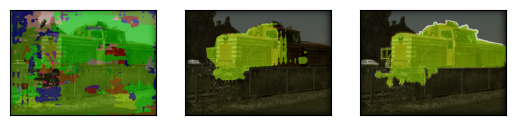

In [6]:
from torchvision.utils import draw_segmentation_masks

simple_num = 1  # 预测样本数量，通过切片实现

for i in range(simple_num):
    img = image_list[i]
    img_float = transforms(img).unsqueeze(0)
    # 对21种类别做了判断，所以有dim=1的长度为21
    out_img = torch.cat([model_random(img_float)['out'], model_pretrain(img_float)['out']], dim=0)
    # 对每个像素的预测结果维度归一化
    normalized_masks = out_img.softmax(dim=1)
    out_masks = normalized_masks.argmax(1) == torch.arange(num_classes)[:, None, None, None]
    out_masks = out_masks.swapaxes(0, 1)
    target_mask = target_list[i][0] == torch.arange(num_classes)[:, None, None]
    # target_mask = target_mask.swapaxes(0, 1)
    out_masks = torch.cat([out_masks, target_mask.unsqueeze(0)], dim=0)
    img_with_masks = [
        draw_segmentation_masks(img, masks=mask, alpha=.6, colors=[tuple(value) for value in color_dict.values()])
        for mask in out_masks
    ]
    show(img_with_masks)

In [92]:
# F.to_pil_image(target_list[0].detach())
image_list[0].size(), target_list[0].size()
tmp = torch.empty(target_list[0].size()).un
for i in range(target_list[0].size()[0]):
    for j in range(target_list[0].size()[1]):
        tmp[i][j] = target_list[]

KeyError: tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)

In [97]:
path = r"D:\useful\program\remote_sensing\semantic_segmentation\data\Pascal VOC 2012\VOCdevkit\VOC2012\SegmentationClass\2007_000063.png"

read_image(path).size()

torch.Size([1, 375, 500])

In [122]:
torch.unique(target_list[0])

tensor([  0,  20, 255], dtype=torch.uint8)

In [126]:
torch.unique(target_list[0][0])

tensor([  0,  20, 255], dtype=torch.uint8)

In [4]:
tes_list = [transforms(i).unsqueeze(0) for i in image_list]
# arr = np.array(tes_list)
mybatch = torch.tensor([item.cpu().detach().numpy() for item in tes_list]).cuda()
# mybatch = None
# for i in image_list:
#     tmp = transforms(i).unsqueeze(0)
#     if mybatch is None:
#         mybatch = tmp
#         continue
#     print(mybatch.size())
#     torch.cat([mybatch, tmp], 0)
mybatch.size()

C:\Users\kangl\AppData\Local\Temp\ipykernel_11468\967503366.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  mybatch = torch.tensor([item.cpu().detach().numpy() for item in tes_list]).cuda()


ValueError: expected sequence of length 375 at dim 3 (got 281)

In [33]:
batch = torch.stack([transforms(d) for d in image_list])
batch.size()

RuntimeError: stack expects each tensor to be equal size, but got [3, 375, 500] at entry 0 and [3, 281, 500] at entry 1

In [11]:
batch = [transforms(d) for d in image_list]
# output = model(batch)['out'] # 字典保存，odict_keys(['out', 'aux'])，out字段对应主体分类器，aux字段对应辅助分类器，此处与pytorch官方对FCN的实现有关
# print(output.shape, output.min().item(), output.max().item())

In [26]:
torch.unique(output)
output

tensor([[[[ 8.4195,  8.4195,  8.4195,  ...,  9.0467,  9.0467,  9.0467],
          [ 8.4195,  8.4195,  8.4195,  ...,  9.0467,  9.0467,  9.0467],
          [ 8.4195,  8.4195,  8.4195,  ...,  9.0467,  9.0467,  9.0467],
          ...,
          [ 8.5221,  8.5221,  8.5221,  ...,  8.0696,  8.0696,  8.0696],
          [ 8.5221,  8.5221,  8.5221,  ...,  8.0696,  8.0696,  8.0696],
          [ 8.5221,  8.5221,  8.5221,  ...,  8.0696,  8.0696,  8.0696]],

         [[ 0.4123,  0.4123,  0.4123,  ..., -1.5058, -1.5058, -1.5058],
          [ 0.4123,  0.4123,  0.4123,  ..., -1.5058, -1.5058, -1.5058],
          [ 0.4123,  0.4123,  0.4123,  ..., -1.5058, -1.5058, -1.5058],
          ...,
          [-1.1418, -1.1418, -1.1418,  ..., -1.0911, -1.0911, -1.0911],
          [-1.1418, -1.1418, -1.1418,  ..., -1.0911, -1.0911, -1.0911],
          [-1.1418, -1.1418, -1.1418,  ..., -1.0911, -1.0911, -1.0911]],

         [[-1.0479, -1.0479, -1.0479,  ..., -2.2133, -2.2133, -2.2133],
          [-1.0479, -1.0479, -

In [12]:
type(batch)

list

In [11]:
# 预训练时的类别，被保存在预训练权重weight里
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}

normalized_masks = torch.nn.functional.softmax(output, dim=1)

tvmonitor_background_masks = [
    normalized_masks[img_idx, sem_class_to_idx[cls]]
    for img_idx in range(len(image_list))
    for cls in ('tvmonitor', '__background__')
]

show(tvmonitor_background_masks)

NameError: name 'normalized_masks' is not defined

shape = torch.Size([2, 375, 500]), dtype = torch.bool


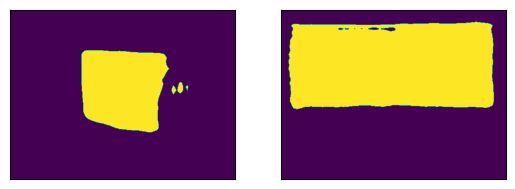

In [5]:
class_dim = 1
boolean_tvmonitor_masks = (normalized_masks.argmax(class_dim) == sem_class_to_idx['tvmonitor'])
print(f"shape = {boolean_tvmonitor_masks.shape}, dtype = {boolean_tvmonitor_masks.dtype}")
show([m.float() for m in boolean_tvmonitor_masks])

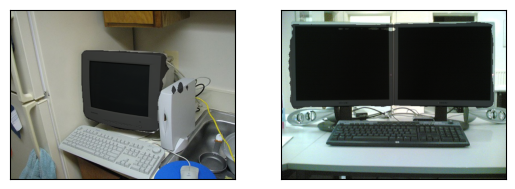

In [6]:
from torchvision.utils import draw_segmentation_masks

tvmonitor_with_masks = [
    draw_segmentation_masks(img, masks=mask, alpha=0.7)
    for img, mask in zip(image_list, boolean_tvmonitor_masks)
]
show(tvmonitor_with_masks)

img1_masks shape = torch.Size([21, 375, 500]), dtype = torch.float32
img1_all_classes_masks = torch.Size([21, 375, 500]), dtype = torch.bool


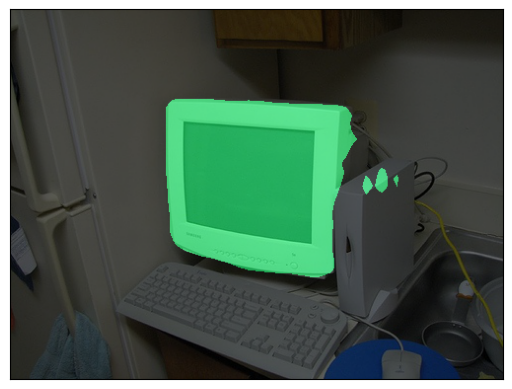

In [7]:
num_classes = normalized_masks.shape[1]
img1_masks = normalized_masks[0]
class_dim = 0
img1_all_classes_masks = img1_masks.argmax(class_dim) == torch.arange(num_classes)[:, None, None]

print(f"img1_masks shape = {img1_masks.shape}, dtype = {img1_masks.dtype}")
print(f"img1_all_classes_masks = {img1_all_classes_masks.shape}, dtype = {img1_all_classes_masks.dtype}")

tvmonitor_with_all_masks = draw_segmentation_masks(img1, masks=img1_all_classes_masks, alpha=.6)
show(tvmonitor_with_all_masks)

shape = torch.Size([21, 2, 375, 500]), dtype = torch.bool


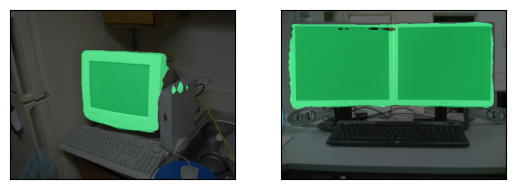

In [8]:
class_dim = 1
all_classes_masks = normalized_masks.argmax(class_dim) == torch.arange(num_classes)[:, None, None, None]
print(f"shape = {all_classes_masks.shape}, dtype = {all_classes_masks.dtype}")
# The first dimension is the classes now, so we need to swap it
all_classes_masks = all_classes_masks.swapaxes(0, 1)

tvmonitors_with_masks = [
    draw_segmentation_masks(img, masks=mask, alpha=.6)
    for img, mask in zip(image_list, all_classes_masks)
]
show(tvmonitors_with_masks)

In [18]:
import torch.nn as nn
m = nn.Linear(5, 6)
input = torch.randn(5, 3)
output = m(input)
print(output.size())

RuntimeError: mat1 and mat2 shapes cannot be multiplied (5x3 and 5x6)

In [16]:
input

tensor([[-0.7568,  0.5658,  0.5812, -0.5869, -0.3793],
        [-1.2820, -0.1173,  0.2910, -0.7072, -1.2120],
        [ 0.7442, -0.9047,  0.4189,  0.2781,  0.3783]])

In [17]:
output

tensor([[-0.6246, -0.2836, -0.0281,  0.1532, -0.2862,  0.0278],
        [-0.9089, -0.3539, -0.0902,  0.0906, -0.7356, -0.0643],
        [ 0.0919, -0.2814, -0.4674,  0.0849, -0.2494,  0.1076]],
       grad_fn=<AddmmBackward0>)